In [3]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import numpy as np

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [1]:
import torch

# Check CUDA availability
print(f"CUDA is available: {torch.cuda.is_available()}")
print(torch.version.cuda)
# Print CUDA device count
if torch.cuda.is_available():
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")

CUDA is available: False
None


### SRGAN CODE

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import time
import psutil

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.conv_block(x)
    
class GeneratorVGG(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorVGG, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64))

        # Upsampling layers
        upsampling = []
        for out_features in range(3):
            upsampling += [
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Sigmoid())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        # Clamp the output to [0, 1] range
        out = torch.clamp(out, min=0.0, max=1.0)
        return out
generator = GeneratorVGG()
transform_lr = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor()
])

generator = GeneratorVGG()
generator.load_state_dict(torch.load('./all_saved_models/generator.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
folder="pipeline_images"
image_name="A-MC (147).png" #change image name

In [5]:
import os
img_path=os.path.join(folder,image_name)

In [7]:
import torch
import psutil

img_low = Image.open(img_path).convert('RGB')
img_lr = transform_lr(img_low).unsqueeze(0)  # Add batch dimension

process = psutil.Process()
print(process.memory_info())
rss_before = process.memory_info().rss / (1024 * 1024)
vms_before = process.memory_info().vms / (1024 * 1024)

start_time = time.time()


with torch.no_grad():
    gen_hr = generator(img_lr)

end_time = time.time()
# Calculate inference time
inference_time = end_time - start_time

rss_after = process.memory_info().rss / (1024 * 1024)
vms_after = process.memory_info().vms / (1024 * 1024)
print(process.memory_info())


print(f"Inference Time: {inference_time}s")
print(f"RSS (Memory): {rss_after - rss_before} MB")
print(f"VMS (Memory): {vms_after - vms_before} MB")




img_lr_np = img_lr.squeeze().permute(1, 2, 0).numpy()
gen_hr_np = gen_hr.squeeze().cpu().permute(1, 2, 0).numpy()

img_lr_np = (img_lr_np - img_lr_np.min()) / (img_lr_np.max() - img_lr_np.min())
gen_hr_np = (gen_hr_np - gen_hr_np.min()) / (gen_hr_np.max() - gen_hr_np.min())
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img_lr_np)
axs[0].set_title('Low-Resolution Image')
axs[0].axis('off')
axs[1].imshow(gen_hr_np)
axs[1].set_title('Generated High-Resolution Image')
axs[1].axis('off')
plt.tight_layout()
plt.show()
gen_hr_pil = Image.fromarray((gen_hr_np * 255).astype('uint8'))

save_dir = 'results/srgan'
os.makedirs(save_dir, exist_ok=True)
base_name = os.path.basename(img_path)
save_path = os.path.join(save_dir, f'{base_name}')
gen_hr_pil.save(save_path)
print(f"Saved generated high-resolution image to: {save_path}")

NameError: name 'Image' is not defined

### Detr Detection Module


image 1/1 E:\[1]-Cascade learning-Unsafe behavior of cranes\ml_mo\pipeline_code\pipeline_images\B-TC (2009).png: 640x640 1 tower crane, 708.5ms
Speed: 4.0ms preprocess, 708.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Inference Time: 1.0545744895935059s
RSS (Memory): 238.17578125 MB
VMS (Memory): 382.09375 MB


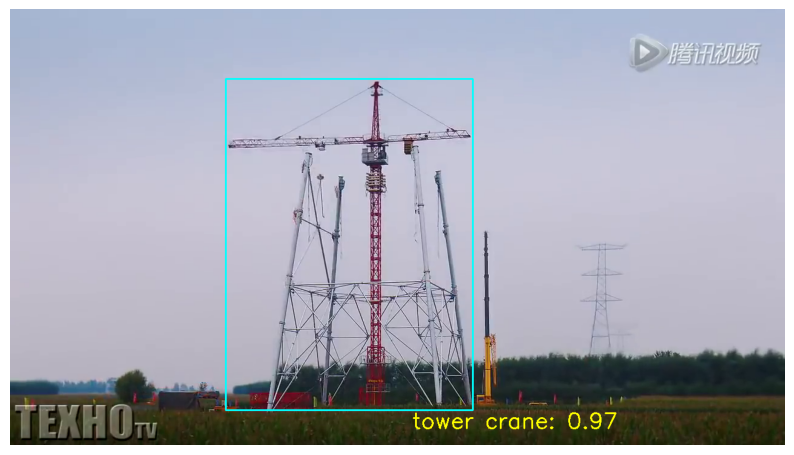

Image saved to results/detr\B-TC (2009).png


In [6]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics import RTDETR
import os
folder="pipeline_images"
image_name="B-TC (2009).png" #change image
img_path=os.path.join(folder,image_name)

weight_model="./all_saved_models/detr_detection_best_model.pt"
model=RTDETR(model=weight_model)
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
process = psutil.Process()
rss_before = process.memory_info().rss / (1024 * 1024)
vms_before = process.memory_info().vms / (1024 * 1024)

start_time = time.time()


results = model.predict(img_path)

end_time = time.time()
# process = psutil.Process()
rss_after = process.memory_info().rss / (1024 * 1024)
vms_after = process.memory_info().vms / (1024 * 1024)

# Calculate inference time
inference_time = end_time - start_time

print(f"Inference Time: {inference_time}s")
print(f"RSS (Memory): {rss_after - rss_before} MB")
print(f"VMS (Memory): {vms_after - vms_before} MB")



for result in results:
    boxes = result.boxes.xyxy.tolist()
    classes = result.boxes.cls.tolist()
    names = model.names
    confidences = result.boxes.conf.tolist()

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)

        class_id = int(classes[i])
        label = f"{names[class_id]}: {confidences[i]:.2f}"

        cv2.rectangle(image, (x1, y1), (x2, y2), color=(255, 255, 0), thickness=2) 
        cv2.putText(image, label, (x2-100, y2 + 30), cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1.2, color=(0, 255, 255), thickness=2)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()
save_path = "results/detr"
os.makedirs(save_path, exist_ok=True)
save_fig_path = os.path.join(save_path, image_name)

cv2.imwrite(save_fig_path, image)
print(f"Image saved to {save_fig_path}")



### Safety Status Classification with DINO 

Using cache found in C:\Users\Mudasir Hussain/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Mudasir Hussain/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Mudasir Hussain/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Mudasir Hussain/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


probabilities: tensor([[2.3991e-05, 9.9985e-01, 1.5543e-07, 1.2942e-04]])
Inference Time: 0.06482839584350586s
RSS (Memory Usage): 3.57421875 MB
VMS (Memory Usage): 4.0078125 MB
predicted_class Unsafe Operations
Image saved to: results/dino\sr_B-TC (2009).png


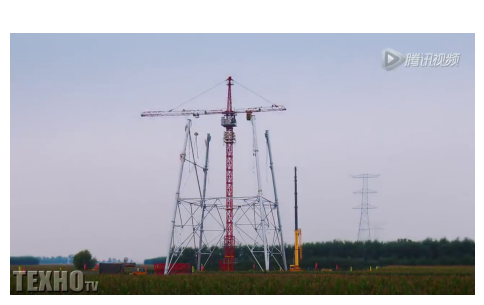

In [7]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import psutil
import time


device = "cpu"
class_names = ['Safe Operations', 'Unsafe Operations', 'Near-Miss Incidents', 'Incidents']

dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self, n_classes=1):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        # x = torch.softmax(x)
        return x

model = DinoVisionTransformerClassifier(n_classes=len(class_names))
model = model.to(device)

# Paths and device setup
folder = "pipeline_images"
image_name = "B-TC (2009).png"  # Change image as needed
img_path = os.path.join(folder, image_name)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# Load the model
model_load_path = "./all_saved_models/dino_model_epoch20.pth" 
model = torch.load(model_load_path)
model = model.to(device)
model.eval()

def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image

def measure_memory():
    process = psutil.Process()
    rss = process.memory_info().rss / (1024 * 1024)
    vms = process.memory_info().vms / (1024 * 1024)
    return rss, vms

def predict_image_class(image_path):
    image = preprocess_image(image_path)
    image = image.to(device)

    # Measure memory before inference
    rss_before, vms_before = measure_memory()
    start_time = time.time()

    with torch.no_grad():
        output = model(image)
        # Apply softmax to get probabilities
        probabilities = F.softmax(output, dim=1)
        # Print the resulting probabilities
        print("probabilities:", probabilities)
    end_time = time.time()

    # Measure memory after inference
    rss_after, vms_after = measure_memory()

    # Calculate and print inference time
    inference_time = end_time - start_time
    print(f"Inference Time: {inference_time}s")

    # Calculate memory usage
    rss_usage = rss_after - rss_before
    vms_usage = vms_after - vms_before

    print(f"RSS (Memory Usage): {rss_usage} MB")
    print(f"VMS (Memory Usage): {vms_usage} MB")

    predicted = torch.argmax(probabilities, dim=1)
    class_label = class_names[predicted.item()]
    print("predicted_class",class_label)
    
    return class_label

def display_image_with_label(image_path, class_label, save_fig=False):
    image = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted: {class_label}", fontsize=16, color='white')
    plt.axis('off')
    
    if save_fig:
        save_dir = 'results/dino'
        os.makedirs(save_dir, exist_ok=True)
        base_name = os.path.basename(image_path)
        save_path = os.path.join(save_dir, f'sr_{base_name}')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        print(f"Image saved to: {save_path}")
    
    plt.show()

predicted_class = predict_image_class(img_path)
display_image_with_label(img_path, predicted_class, save_fig=True)


### Activity Classification with ViT for Mobile Crane

In [8]:
!pip install memory_profiler


In [ ]:
# Define image path
folder = "pipeline_images"
image_name = "A-MC (118).png"
img_path = os.path.join(folder, image_name)



Inference Time: 0.1160 seconds
RSS (Memory Usage): 1.23 MB
VMS (Memory Usage): 0.00 MB
Predicted Class: a11_Outriggers
Consequences Score: 20.00
Consequences Level: Negligible Consequences (Safety Classification)
Image saved to: results/mobile_vit\sr_A-MC (118).png


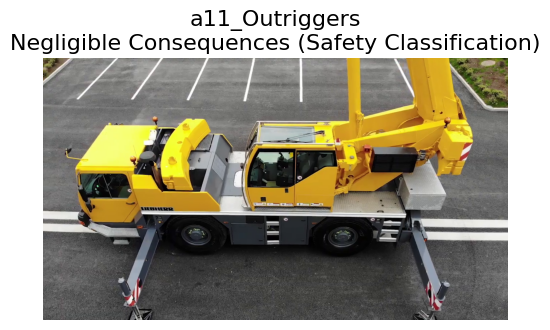

In [11]:
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import psutil
import time

# Define class names and corresponding Consequence Scores in the same order
class_names = [
        'a41_Collapse',
         'a42_Tipping over',
         'a43_Fall of crane jib, boom, other parts',
         'a44_Fall of loads',
         'a45_Collision',
         'a46_Struck-by',
         'a47_Struck-by objects',
         'a31_Potential colision',
         'a32_Potential struck-by',
         'a33_Load tipping or shifting',
         'a11_Outriggers',
         'a12_Movement',
         'a13_Lifting operation',
         'a14_Safe access to the deck',
         'a21_Operating on unsafe terrian',
         'a22_Unstable lifting operation',
         'a23_Unclear division of work area',
         'a24_Unsafe access to a working crane',
         'a25_Operating near power lines'
    ]

consequence_scores = [
    80, 80, 80, 80, 80, 80, 80, 60, 60, 60, 20, 20, 20, 20, 
    40, 40, 40, 40, 40
]

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)

# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

# Custom head for ViT model
class CustomHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super(CustomHead, self).__init__()
        self.fc1 = nn.Linear(in_features, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

# Modify model head
num_features = model.heads[0].in_features
num_classes = len(class_names)
model.heads[0] = CustomHead(num_features, num_classes)
model.load_state_dict(torch.load('./all_saved_models/vit_mobile_crane_activity_model_epoch10.pth'))
model = model.to(device)
model.eval()

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image

# Function to predict image class and map to consequences
def predict_consequence(image_path):
    image = preprocess_image(image_path).to(device)
    
    # Memory and inference time monitoring
    process = psutil.Process(os.getpid())
    rss_before = process.memory_info().rss / (1024 * 1024)
    vms_before = process.memory_info().vms / (1024 * 1024)
    start_time = time.time()
    
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1).cpu().numpy().flatten()
    
    end_time = time.time()
    rss_after = process.memory_info().rss / (1024 * 1024)
    vms_after = process.memory_info().vms / (1024 * 1024)
    inference_time = end_time - start_time
    
    print(f"Inference Time: {inference_time:.4f} seconds")
    print(f"RSS (Memory Usage): {rss_after - rss_before:.2f} MB")
    print(f"VMS (Memory Usage): {vms_after - vms_before:.2f} MB")
    
    # Calculate Consequence Score using the consequence_scores list in the correct order
    consequence_score = sum(prob * consequence_scores[i] for i, prob in enumerate(probabilities))
    # Assign the two-decimal rounded value directly to consequence_score
    consequence_score = float(f"{consequence_score:.2f}")

    # Determine Consequence Level based on the score
    if consequence_score <= 20:
        consequence_level = "Negligible Consequences (Safety Classification)"
    elif 20 < consequence_score <= 40:
        consequence_level = "Mild Consequences (Unsafe Classification)"
    elif 40 < consequence_score <= 60:
        consequence_level = "Moderate Consequences (Near Miss Incident)"
    else:
        consequence_level = "Severe Consequences (Incident)"
    
    # Display Results
    predicted_class = class_names[output.argmax().item()]
    print(f"Predicted Class: {predicted_class}")
    print(f"Consequences Score: {consequence_score:.2f}")
    print(f"Consequences Level: {consequence_level}")
    return predicted_class, consequence_level

def display_image_with_label(image_path, class_label, consequence_level, save_fig=False):
    image = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"{class_label}\n{consequence_level}", fontsize=16, color='black')
    plt.axis('off')
    
    if save_fig:
        save_dir = 'results/mobile_vit'
        os.makedirs(save_dir, exist_ok=True)
        base_name = os.path.basename(image_path)
        save_path = os.path.join(save_dir, f'sr_{base_name}')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        print(f"Image saved to: {save_path}")
    
    plt.show()

# Define image path
folder = "pipeline_images"
image_name = "A-MC (118).png"
img_path = os.path.join(folder, image_name)

# Run inference and display results
predicted_class, consequence_level = predict_consequence(img_path)
display_image_with_label(img_path, predicted_class, consequence_level, save_fig=True)


### Activity Classification with ViT for Tower Crane

Inference Time: 0.1037 seconds
RSS (Memory Usage): 3.40 MB
VMS (Memory Usage): 0.00 MB
Predicted Class: b42_Tipping over
Consequences Score: 80.00
Consequences Level: Severe Consequences (Incident)
Image saved to: results/tower_vit\sr_B-TC (828).png


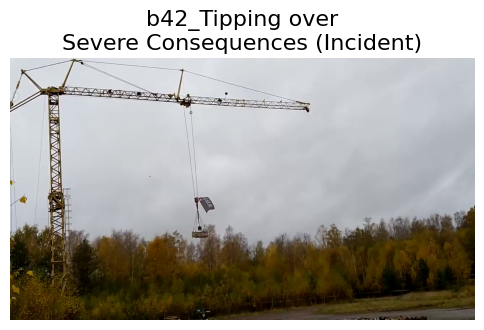

In [12]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import psutil
import time
import os

class_names = [
        'b41_Collapse',
         'b42_Tipping over',
         'b43_Fall of crane jib, boom, other parts',
         'b44_Fall of load',
         'b45_Collision',
         'b46_Struck-by',
         'b47-Struck by objects',
         'b31_Potential collision',
         'b32_Potential struck-by',
         'b33_ Load tipping or shifting',
         'b11_Assembling,dismantling',
         'b12_Erection',
         'b13_Lifting operation',
         'b14_Safe access to the deck',
         'b21_Inadequate use of PPE',
         'b22_Unstable lifting operation',
         'b23_Unclear division of work area',
         'b24_Unsafe access to a working crane',
         'b25_Operating near power lines'
        ]
consequence_scores = [
    80, 80, 80, 80, 80, 80, 80, 60, 60, 60, 20, 20, 20, 20, 
    40, 40, 40, 40, 40
]

class CustomHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super(CustomHead, self).__init__()
        self.fc1 = nn.Linear(in_features, 128)  
        self.fc2 = nn.Linear(128, num_classes)  

    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)  
        x = self.fc2(x)
        return x

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)

# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

num_features = model.heads[0].in_features
num_classes = len(class_names)
model.heads[0] = CustomHead(num_features, num_classes)

for param in model.heads[0].parameters():
    param.requires_grad = False

model.load_state_dict(torch.load('./all_saved_models/vit_tower_crane_activity_model_epoch10.pth'))
model = model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image

def measure_memory():
    process = psutil.Process()
    rss = process.memory_info().rss / (1024 * 1024)  
    vms = process.memory_info().vms / (1024 * 1024)  
    return rss, vms

# Function to predict image class and map to consequences
def predict_consequence(image_path):
    image = preprocess_image(image_path).to(device)
    
    # Memory and inference time monitoring
    process = psutil.Process(os.getpid())
    rss_before = process.memory_info().rss / (1024 * 1024)
    vms_before = process.memory_info().vms / (1024 * 1024)
    start_time = time.time()
    
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1).cpu().numpy().flatten()
    
    end_time = time.time()
    rss_after = process.memory_info().rss / (1024 * 1024)
    vms_after = process.memory_info().vms / (1024 * 1024)
    inference_time = end_time - start_time
    
    print(f"Inference Time: {inference_time:.4f} seconds")
    print(f"RSS (Memory Usage): {rss_after - rss_before:.2f} MB")
    print(f"VMS (Memory Usage): {vms_after - vms_before:.2f} MB")
    
    # Calculate Consequence Score using the consequence_scores list in the correct order
    consequence_score = sum(prob * consequence_scores[i] for i, prob in enumerate(probabilities))
    # Assign the two-decimal rounded value directly to consequence_score
    consequence_score = float(f"{consequence_score:.2f}")
    
    # Determine Consequence Level based on the score
    if consequence_score <= 20:
        consequence_level = "Negligible Consequences (Safety Classification)"
    elif 20 < consequence_score <= 40:
        consequence_level = "Mild Consequences (Unsafe Classification)"
    elif 40 < consequence_score <= 60:
        consequence_level = "Moderate Consequences (Near Miss Incident)"
    else:
        consequence_level = "Severe Consequences (Incident)"
    
    # Display Results
    predicted_class = class_names[output.argmax().item()]
    print(f"Predicted Class: {predicted_class}")
    print(f"Consequences Score: {consequence_score:.2f}")
    print(f"Consequences Level: {consequence_level}")
    return predicted_class, consequence_level

def display_image_with_label(image_path, class_label, consequence_level, save_fig=False):
    image = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"{class_label}\n{consequence_level}", fontsize=16, color='black')
    plt.axis('off')
    
    if save_fig:
        save_dir = 'results/tower_vit'
        os.makedirs(save_dir, exist_ok=True)
        base_name = os.path.basename(image_path)
        save_path = os.path.join(save_dir, f'sr_{base_name}')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        print(f"Image saved to: {save_path}")
    
    plt.show()

# Paths and device setup
folder = "pipeline_images"
image_name = "B-TC (828).png"  # Change image as needed
img_path = os.path.join(folder, image_name)

# Run inference and display results
predicted_class, consequence_level = predict_consequence(img_path)
display_image_with_label(img_path, predicted_class, consequence_level, save_fig=True)
